<a href="https://colab.research.google.com/github/irisnoww/Experiment-Analysis/blob/main/Twitter_Ads_Experiment_Analysis_A_B_Test_Analysis_Framework_by_Iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Experiment Analysis

### 1. Experiment Overview
1.1 Experiment Summary 

A Twitter Ads new product was tested, which bills advertisers each time their ads appear in a user's viewport, presumbably these engagement data can be received at a lower latency and could potentially reduce overspending.

- Goal: 
  
    Reduce campaign advertising overspend amount/ cost
    Increase overall ads revenue for ads
- A/B test Setup: 

  - Randomly split advertisers on the platform: 50% to control, 50% to treatment
  - Duration: one-week

1.2 Experiment Hypothesis 

The hypothesis was that the new product would reduce the amount of campaign advertising overspend 


1.3 Experiment Details 
- Unit of diversion is per advertiser
- Unit of Analysis is per campaign

Assumptions:

1) each advertiser and campaign are independent; 

2) each advertiser only has 1 campaign during the experiment (If in reality one advertiser can have multiple campaigns then we need to do more nuanced analyses, e.g. bootstrap);

3) no other factors affects the overspend results besides the new product. The effects not calibrated with other tested features.

### 2.Import Packages and Helper Functions 

Overview:
*   sample_ratio_check: chi-sqaured to check for Sample Ratio Mismatch
*   welch_ttest: perform welch ttest on two independent samples when equal varianc is not assumed; can be used for samples of different sample size
*   z test_unpooled: perform z test on two independent samples when equal variance is not assumed; different sample size





In [ ]:
# import libraies 
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px

# import statistical packages
import scipy
from scipy import stats
from scipy.stats import ttest_ind, norm, t

import warnings
warnings.filterwarnings('ignore')

# import data into notebook
import io

In [ ]:
# helper functions to preprocess raw data
def get_control_treatment_desc(dataset):

  """
  Returns descriptive stats for A/B test results dataset
  sample input format:
  | treatment | metric|
  ---------------------
  | True      |  CTR  |
  ---------------------
  | False     |  CTR  |

  """
  
  control = dataset[dataset['treatment'] == False].iloc[:,1] 
  treatment = dataset[dataset['treatment'] == True].iloc[:,1]

  control_size, treatment_size = len(control), len(treatment)

  return control, treatment, control_size, treatment_size


In [ ]:
class ExperimentResultAnalyze:
  """ 
  |  Class representing A/B test result analysis framework.
  |  Attributes
  |   ----------
  |   alpha : float default 0.05
  |       Significance level       
  |   split : float, default 0.5
  |       Sample split ratio
  |   alternative : str, default 'greater'
  |       one-tailed or two-tailed test
  |  Methods defined here:
  """ 

  def __init__(self, alpha = 0.05, split = 0.5, alternative = 'greater'):

    self.alpha = alpha # define significance level
    self.split = split # define sample ratio split
    self.alternative = alternative # define hypothesis: {'two-sided', 'less', 'greater'}

  def sample_ratio_check(self, dataset):
      """
      perform chi-squared test to identify if there is sample ratio mismatch between control and treatment group
      
      Parameters
      ----------
      dataset: dataframe with group and metric coloumns
      
      Returns
      ----------
      control_size: size of control group
      control_%: control group proportion
      treatment_size: size of treatment group
      treatment_%: treatment group proportion
      chi_pvalue: calculated p-value
      pvalue: p-value depends on alternative
      conclusion: whether there is sample ratio mismatch between group by comparing pvalue 
      """
      _, _, control_size, treatment_size = get_control_treatment_desc(dataset) # get basic stats from get_control_treatment_desc

      # compute proportion of control and treatment group
      total_traffic = control_size + treatment_size
      control_prop = control_size / total_traffic 
      treatment_prop = treatment_size / total_traffic

      # construct (observed, expected) contingency table
      observed = [control_size, treatment_size] # observed split from collected data
      expected = [int(total_traffic * self.split), int(total_traffic * self.split)] # expected split ratio from experiment design

      chi = stats.chisquare(observed, expected) 

      conclusion = "Sample Ratio Mismatch may be present" if chi[1] < 0.01 else "Sample Ratio Mismatch not identified"
      
      return pd.Series({
                        'control_size': int(control_size),
                        'control_%':round(control_prop,4),
                        'treatment_size':int(treatment_size),
                        'treatment_%':round(treatment_prop,4),
                        'chi_pvalue': chi[1],
                        'conclusion' : conclusion
                        })
      
      
  def welch_ttest(self, dataset):
      """
      perform Welch's t-test, which does not assume equal population variance
      
      Parameters
      ----------
      dataset: dataframe with group indicator and metric coloumns
      
      Returns
      ----------
      control mean: mean of evaluation metric for control group
      treatment mean: mean of evaluation metric for treatment group
      Welch's t-test statistics ：the calculated t-statistic.
      t-critical: t critical value depends on alternative and degree of freedom
      confidence interval: compute using critical t value and unpooled standard deviation
      conclusion: significant or not based on critical t value 
      """
      control, treatment, control_size, treatment_size = get_control_treatment_desc(dataset) # get basic stats from get_control_treatment_desc

      # compute mean and std for control and treatment
      control_mean = control.mean()
      treatment_mean = treatment.mean()
      control_std = np.std(control)
      treatment_std = np.std(treatment)

      # compute t-statistics
      d = control_mean - treatment_mean # mean difference between control and treatment
      unpooled_std = np.sqrt(control_std **2 / control_size + treatment_std**2 / treatment_size) # unpooled standard deviation (used for unequal var)
      tstats = d/unpooled_std 

      dof = (control_std **2/control_size  + treatment_std**2/treatment_size)**2 / ((control_std **2/control_size)**2 / (control_size-1) + (treatment_std**2/treatment_size)**2 / (treatment_size-1))

      # compute critical t value
      if self.alternative == "two-sided":
        t_critical = t.ppf(1-self.alpha/2, dof)
      else:
        t_critical = t.ppf(1-self.alpha, dof)
      
      # compute confidence interval
      margin_error = t_critical* unpooled_std
      CI = [round(d-margin_error,4), round(d+margin_error,4)]

      # conclusion based on comparison between calculated p-value and defined alpha
      conclusion = 'Reject null hypothesis' if tstats > t_critical else 'Do not reject null hypothesis' 
      
      return pd.Series({
                        'control_mean':round(control_mean,4),
                        'control_std':round(control_std,4),
                        'treatment_mean':round(treatment_mean,4),
                        'treatment_std':round(treatment_std,4),
                        'lift':d,
                        "t-statistics" :round(tstats,4),
                        't-critical':round(t_critical,4),
                        'confidence_interval': CI,
                        'conclusion':conclusion
                        })
      
 
  def ztest_unpooled(self, dataset):
      """
      perform z test for 2 independent proportions, used unpooled variance, which does not assume equal population variance
      
      Parameters
      ----------
      dataset: dataframe with group indicator and metric coloumns
      
      Returns
      ----------
      control proportion: proportion of evaluation metric for control group 
      treatment proportion: proportion of evaluation metric for treatment group 
      z-statistics ：the calculated z-statistic.
      z-critial: z critical value depends on alternative and alpha
      confidence interval
      conclusion: significant or not based on p-value and defined alpha
      """
      control, treatment, control_size, treatment_size = get_control_treatment_desc(dataset)

      control_prop = control.sum() /control_size
      treatment_prop = treatment.sum()/treatment_size

      unpooled_std = np.sqrt(((control_prop *(1-control_prop)) / control_size) + ((treatment_prop*(1-treatment_prop)) / treatment_size))
      
      d = control_prop - treatment_prop
      zstats = d / unpooled_std # calculated z statistics

      # calculated p-value based on defined hyphothesis: two-sided, greater or less
      if self.alternative == "two-sided":
          z_critical = norm.ppf(1 - self.alpha/2)
      else:
          z_critical = norm.ppf(1 - self.alpha)


      # calculate confidence interval
      margin_error = z_critical* unpooled_std
      CI = [round(d-margin_error,4), round(d+margin_error,4)]
      # conclusion based on comparison between calculated p-value and defined alpha
      conclusion = 'Reject null hypothesis' if zstats > z_critical  else 'Do not reject null hypothesis'

      return pd.Series({
                        'control_mean':round(control_prop,4),
                        'treatment_mean':round(treatment_prop,4),
                        'lift':d,
                        'z-statistics': round(zstats,4),
                        'z-critical':round(z_critical,4),
                        'confidence_interval': CI,
                        'conclusion' : conclusion
                        })




### 3. Exploratory Data Analysis

In [ ]:
# load data from local file
from google.colab import files
uploaded = files.upload()

Saving analytical_take_home_data_v3.csv to analytical_take_home_data_v3.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['analytical_take_home_data_v3.csv'])) # store data into Pandas Dataframe

In [ ]:
df.info() # get basic information of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15474 entries, 0 to 15473
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   treatment        15474 non-null  bool   
 1   company_size     15474 non-null  object 
 2   campaign_spend   15474 non-null  float64
 3   campaign_budget  15474 non-null  float64
dtypes: bool(1), float64(2), object(1)
memory usage: 377.9+ KB


##### Missing data check

In [ ]:
# check if any missing data 
df.isna().any()

treatment          False
company_size       False
campaign_spend     False
campaign_budget    False
dtype: bool

In [ ]:
# check if any duplicates
df[df.duplicated()]

,treatment,company_size,campaign_spend,campaign_budget



Before digging into analysis, let's take a look of the collected data and make sure we understand them properly. 



In [ ]:
df.sample(5) # get samples from dataframe to have look and feel

,treatment,company_size,campaign_spend,campaign_budget
9622,True,small,9.9385,7.6310
7671,False,small,40.7803,39.4415
4321,False,small,6.0279,5.0811
8663,True,large,32.4449,22.2693
2321,False,medium,89808.5159,131500.8589


We have 15474 rows in our data with following columns:
- treatment: False -> control / True -> treatment
- company size: large, medium, small. 
- campaign_spend: Campaign spend during the experiment
- campaign_budget: Campaign budget during the experiment


##### Descriptive Statistics

Let's check some descriptive statistics, slicing by group and by company size.

Given we already know that businesses of different sizes
use Twitter ads in very different ways and may
react differently to the new product, we will further explore the data by segment of company sizes.

In [ ]:
# group by control & treatment group and check basic stats 
df.groupby(['treatment']).agg(['count','mean','std','min','max']).apply(lambda x: round(x, 2))

campaign_spend                     ... campaign_budget                   
                   count     mean       std  ...             std   min          max
treatment                                    ...                                   
False               7733  3950.85  34024.71  ...        47765.75  0.31   2119520.48
True                7741  5854.24  85623.12  ...       131623.54  0.09  10242888.21

[2 rows x 10 columns]

Overall, control and treatment split looks similar to the experiment design of 50-50. But we will need to make sure the split is random as expected. Looking at campaign spend and campaign budget, seems like treatment group's 'mean' and 'std' are a bit higher than in control group.

Let's slice data by company size:

In [ ]:
# group by control & treatment group and by company sizeand check basic stats 
df.groupby(['company_size','treatment']).agg(['count','mean','std','min','max']).apply(lambda x: round(x, 2))

campaign_spend            ... campaign_budget             
                                count      mean  ...             min          max
company_size treatment                           ...                             
large        False               2701   5404.57  ...            0.68   1118716.39
             True                2445  14073.80  ...            0.60  10242888.21
medium       False                735   4473.76  ...            0.31    395780.58
             True                 692   3674.34  ...            1.10    386967.75
small        False               4297   2947.63  ...            0.33   2119520.48
             True                4604   1816.81  ...            0.09    355943.07

[6 rows x 10 columns]

Okay, when segmenting data by company size:
- advertisers distributions for each company size are just roughly 50-50, all with unequal sample size
- In treatment group, large company's campaign budget and spend on average is greater than in control, vice versa for small company, while medium size's are much closer

Let's do some visualizations to better interpret the data

##### Visualization



---


Advertisers distribution between control v.s. treatment - Bar Chart

In [ ]:
# campaigns split between control and treatment group
fig = px.histogram(df, x='treatment', color="treatment", height= 400, width= 400,title = ' #of campaigns in control v.s. treatment')
fig.show()

In [ ]:
# plot countplot by different compant
px.histogram(df, x='company_size', color="treatment", barmode='group',height= 400, width= 800, title = ' #of campaigns in control v.s. treatment by company')

From bar chart, we could found out that the difference in sample ratio split for large and small company is relatively large compared to medium company



---


Campaign budget distribution - Box Plot

In [ ]:
# box plot to represent the distribution of campaign_budget
fig = px.box(df, x = 'company_size', y = 'campaign_budget', color = 'treatment',title = ' Campaigns budget in control v.s. treatment by company')
fig.show()

In [ ]:
# box plot to represent the distribution of campaign_spend
fig = px.box(df, x = 'company_size', y = 'campaign_spend', color = 'treatment',title = ' Campaigns Spend in control v.s. treatment by company')
fig.show()

The box plot presents that:
- Comparing companies of different sizes within control groups: small companies' budgets have a wide range with a large variance; the medium and large companies are relatively concentrated.
- Comparing companies between control and treatment: support previous observations on small companies' budge is lower in treatment while large companies are greater.

### 4.Experiment Analysis

After we have a better sense of the data, let's explore further and answer the questions!

#### Q1. How many campaigns have overspend of greater than 1% of their budget in the control group? In the treatment group?

In [ ]:
# define overspend: overspend = campaign_spend - campaign_budget
# add computed overspend metrics to columns
df['overspend_abs'] = (df['campaign_spend'] - df['campaign_budget']) # overspend absolute number
df['overspend_per'] = (df['campaign_spend'] - df['campaign_budget'])/df['campaign_budget'] # overspend percentage
df['is_overspend'] = np.where((df['campaign_budget'] < df['campaign_spend']), 1,0) # overspend indicato binary variable

In [ ]:
percent = 0.01 # overspend percentage threshold
overspend_threshold = df[df['overspend_per'] > percent].groupby(['treatment']).size().to_frame('campaigns_count') # count the number of campigns (overspend_per>0.01)
overspend_threshold

,campaigns_count
treatment,
False,5716
True,5180


There are 5716 campaigns(74%) in the control group and 5180(67%) in the treatment group that have overspend of greater than 1% of their budget.

I would also like to check this number by company size:

In [ ]:
# segment by company size and group
overspend_by_company = df[df['overspend_per'] > percent].groupby(['company_size','treatment']).size().to_frame('campaigns_count')
overspend_by_company

campaigns_count
company_size treatment                 
large        False                 1875
             True                  1504
medium       False                  452
             True                   414
small        False                 3389
             True                  3262

Looks like when aggregating by company sizes, fewer campaigns have overspend in treatment than in control for the given threshold. 

Let's continue the analysis to see if the new product has a true effect here.

#### Q2. Was the new product effective at reducing overspend, and was it more or less effective depending on the company size? Put together an analysis describing how the treatment affected overspend.

To exam the effectiveness of the treatment, we need to perform Hypothesis testing on A/B test results and see if we can make conclusions based on it. I will follow the below framework to analyze the results step by step.



1.   Define Metrics
2.   Sanity Check on Sample Ratio Mismatch 
3.   Formulate Hypothesis 
4.   Perform Hypothesis testing to exam treatment effects
5.   Experiment Improvement

#### Define Metrics
There are 2 types of metrics we should choose to evaluate this experiment:
- Invariant metrics: 
    
    sanity check to make sure our experiment conducted as planned;     
    also need to consider organizational guardrail metrics, e.g revenue/engagement related metrics
- Evaluation metrics: relevant to the business goals, should consider sensitivity and robustness  

Based on the above considerations, we define the metrics as follows:

**Invariant metrics:**
  - Advertiser sample ratio: make sure the control and treatment samples to be sized according to the plan
  - Average budget per group: make sure users won't reduce using Twitter ads or lower budget because of new products (they may concern about less effectiveness of ads with the same amount of budget)

**Evaluation metrics:**

The goal of the Experiment is to reduce overspend on campaign advertising, which is also relevant to the business goal(reduce cost/increase revenue). The overspend percentage change and overspend proportion can reflect the success of the experiment
  - overspend percentage: Average overspend percentage per advertiser
  - overspend proportion: Proportion of overspend per group

Please see the analysis below for justification on evaluation metrics:

In [ ]:
# compute basic stats to choose evaluation metrics
df.groupby(['treatment'])[['overspend_abs','overspend_per','is_overspend']].agg(('count','mean','std')).apply(lambda x: round(x, 2))

overspend_abs                     ... is_overspend            
                  count     mean       std  ...        count  mean   std
treatment                                   ...                         
False              7733  -690.98  18343.18  ...         7733  0.81  0.39
True               7741 -1047.99  57417.17  ...         7741  0.74  0.44

[2 rows x 9 columns]

Based on previous EDA and the above stats: 
Overspend percentage as primary Metric

1)given baseline rate (25%) and minimum detectable effects, there are enough sample size to detect effects(sensitive) 

2) normalized by campaign budget, more stable (robust)

Overspend proportion as secondary metric: 

Overspend proportion is less sensitive than primary metric as the new product aims to reduce overspending not totally avoid overspend. But these two metrics should move in the same direction


After we decide on evaluation metrics, we will need to do some sanity checks on invariant metrics to make sure our data is valid.

#### Sanity Check
Sanity Check helps to verify that the experiment was conducted as planned and that other factors did not influence the data which we collected. This also makes sure that the data collection process was correct.

For the following analysis, I will use defined [helper functions ](https://colab.research.google.com/drive/1OzWw5VPlWr_MAlfH5bLadsliIDNPLVAC#scrollTo=F_etUHqV9kLv&line=1&uniqifier=1)above to perform relevant tests.

Let's first take a look at the whole universe, and calculate relevant metrics for control and treatment groups.

In this experiment, our split ratio is 0.5 

In [ ]:
abtest = ExperimentResultAnalyze(split=0.5)

In [ ]:
abtest.sample_ratio_check(df).to_frame('sample_ratio_check') # perform sanity check on whole dataset

,sample_ratio_check
control_size,7733
control_%,0.4997
treatment_size,7741
treatment_%,0.5003
chi_pvalue,0.948722
conclusion,Sample Ratio Mismatch not identified


Based on the above, looks like Sample Ratio Mismatch is not identified. So we can continue our analysis.

#### Perform Hypothesis testing to exam treatment effects


After sanity check, the next step is to look at the difference between the control and experiment groups about the evaluation metrics to make sure the difference is there, that it is statistically significant.


Also, to make launch decisions, we will need to check if the difference is practically significant. 


**Hypothesis:**

- H0: There is no difference in overspend percentage between the control group and test group

 X1 = X2

- H1: overspend percentage in the treatment group is lower than that in the control group

  X1 > X2


**This is a one-tailed ('greater') test； we choose significance level 0.05, we can assume the practical significant boundary is 0.05**




Based on what we observed before, the control and treatment groups have different sample sizes. Therefore, we could use hypothesis testing with an unpooled standard deviation, which doesn't assume equal variance.

**Evaluation Metrics**

- Overspend percentage: for mean difference, we perform Welch's t-test using unpooled standard deviation
- Overspend proportion: for proportion, we perform z test with an unpooled standard deviation

A metric is statistically significant:  
- if calculated test statistics is greater than the critical value
- if the confidence interval **does not include 0** 

*Assumption: for large random samples, sample mean of metrics follow normal distribution

**Evaluation Metric 1: Overspend percentage**

Helper Functions: 

`abtest_95 = ExperimentResultAnalyze(alpha=0.05, split=0.5, alternative='greater')`

`abtest_95.welch_ttest `

In [ ]:
# analyze result with 95% confidence level
abtest_95 = ExperimentResultAnalyze(alpha=0.05, split=0.5, alternative='greater') # initialize ExperimentResultAnalyze class with defined parameters

In [ ]:
# perform Welch's t-test 
test_result_overspend_per = abtest_95.welch_ttest(df[['treatment','overspend_per']]).to_frame('overspend_per_t_test').reset_index()
test_result_overspend_per

,index,overspend_per_t_test
0,control_mean,0.2532
1,control_std,0.7387
2,treatment_mean,0.1761
3,treatment_std,0.6983
4,lift,0.077162
5,t-statistics,6.677
6,t-critical,1.645
7,confidence_interval,"[0.0582, 0.0962]"
8,conclusion,Reject null hypothesis


Result shows that $t$-statistics > $t$-critical, and confidence interval does not include 0. Looks like we have some evidence to reject the null hypothesis $H_0$, which means that our new product reduces overspend overall.


But let's exam if it's still significant when analyzed by the segment of company size.

In [ ]:
# perform Welch's t-test on each company size
test_result_company = df.groupby(['company_size'])[['treatment','overspend_per']].apply(abtest_95.welch_ttest)
test_result_company 

,control_mean,control_std,treatment_mean,treatment_std,lift,t-statistics,t-critical,confidence_interval,conclusion
company_size,,,,,,,,,
large,0.1229,0.5397,0.0326,0.4523,0.090297,6.5245,1.6452,"[0.0675, 0.1131]",Reject null hypothesis
medium,0.0456,0.3994,0.0514,0.4651,-0.005874,-0.2552,1.6460,"[-0.0438, 0.032]",Do not reject null hypothesis
small,0.3706,0.8601,0.2710,0.8102,0.099681,5.6188,1.6450,"[0.0705, 0.1289]",Reject null hypothesis


Test results show that only large and small size company are statistically significant while medium-size company is not. Let's plot confidence interval and compare to practical significance level to see if the results are also practically significant.

We select 0.05 as practical boundary.

In [ ]:
def confidence_interval_plot(df, practical_significance):
  """ Plot confidence interval v.s.practical boundary
  """
  from matplotlib.pyplot import cm
  y = 1
  color = cm.rainbow(np.linspace(0, 1, len(df)+1)) 
  while y <= len(df): 
    for i, color in zip(range(len(df)), color):
      lower = df['confidence_interval'][i][0] # get lower confidence interval
      upper = df['confidence_interval'][i][1] # get upper confidence interval
      y += 1
      plt.plot((lower,upper),(y,y),'ro-',color=color, label = df.index[i])
      plt.plot((0,practical_significance),(y,y),'ro-',color='red', label = 'practical significance')
  
  plt.yticks([2,3,4],list(df.index))
  plt.title('Confidence Interval ')
  plt.legend(bbox_to_anchor=(1.05, 1))


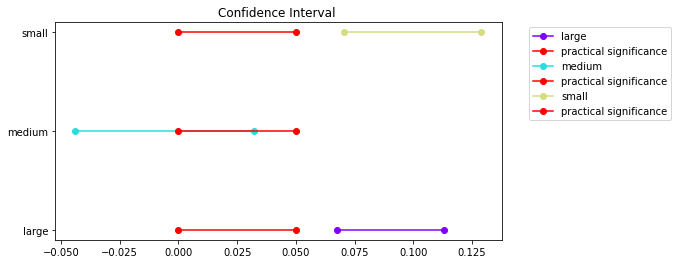

In [ ]:
# plot confidence interval
confidence_interval_plot(test_result_company, 0.05)

The above chart shows that both small and large sizes of company are also practically significant.

Continue to analyze the secondary metric.



**Evaluation Metric 2: overspend proportion**

Helper functions:

`abtest_95 = ExperimentResultAnalyze(alpha=0.05, split=0.5, alternative='greater')`

`abtest_95.ztest_unpooled `

In [ ]:
# perform z test 
abtest_95.ztest_unpooled(df[['treatment','is_overspend']]).to_frame('is_overspend_z_test')

,is_overspend_z_test
control_mean,0.8091
treatment_mean,0.7391
lift,0.0700779
z-statistics,10.46
z-critical,1.6449
confidence_interval,"[0.0591, 0.0811]"
conclusion,Reject null hypothesis


We have similar results as our primary metric when the test for the whole universe

In [ ]:
# perform z test on each company size
test_result_prop = df.groupby(['company_size'])[['treatment','is_overspend']].apply(abtest_95.ztest_unpooled)
test_result_prop

,control_mean,treatment_mean,lift,z-statistics,z-critical,confidence_interval,conclusion
company_size,,,,,,,
large,0.7730,0.6937,0.079386,6.4419,1.6449,"[0.0591, 0.0997]",Reject null hypothesis
medium,0.7347,0.6908,0.043942,1.8343,1.6449,"[0.0045, 0.0833]",Reject null hypothesis
small,0.8445,0.7704,0.074126,8.9255,1.6449,"[0.0605, 0.0878]",Reject null hypothesis


Test results show that there is significant improvement in all sizes of company.

Let's plot confidence interval to compare with practical boundary:


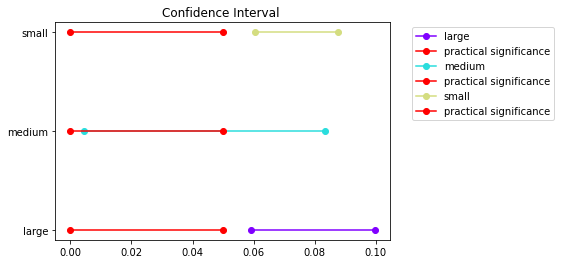

In [ ]:
confidence_interval_plot(test_result_prop, 0.05)

Medium's confidence interval overlapps with practical boundary, indicating not practically significant.

**Conclusion:**
Therefore, combing the test results with primary metric and secondary metric, we can conclude that the new product is more effective to large and small companies but not to medium companies. 




#### Q3. A product manager on the team is concerned that certain advertisers in the treatment group are entering lower budgets because they are wary of the new product. Provide some evidence to support their suspicions, or show that any differences in budgets are likely due to random fluctuations.

To testify this argument, we could also perform hypothesis testing to see if there is a true difference of average budget between the control and the treatment group:



1.   Define Evaluation Metric: 
        
        Average budget 
2.   Formulate Hypothesis
        
        H0: there is no difference in budget between the control and treatment group
        H1: budge in the control group is higher than in the treatment group
3.   Perform welch_ttest on the evaluation metric
4.     conclusion



In [ ]:
# check campaign_budget stats by group
df.groupby(['treatment'])[['campaign_budget']].agg(['mean','std']).apply(lambda x: round(x, 2))

campaign_budget           
                     mean        std
treatment                           
False             4641.83   47765.75
True              6902.23  131623.54

In [ ]:
# check campaign_budget stats by group and company size 
df.groupby(['company_size','treatment'])[['campaign_budget']].agg(['mean','std']).apply(lambda x: round(x, 2))

campaign_budget           
                                  mean        std
company_size treatment                           
large        False             5933.97   47284.51
             True             17561.83  232877.14
medium       False             6342.86   31512.53
             True              4612.67   24929.80
small        False             3538.66   50286.87
             True              1585.48   12421.00

In [ ]:
# perform Welch's t-test on each company size
abtest_95.welch_ttest(df[['treatment','campaign_budget']]).to_frame('t_test')

,t_test
control_mean,4641.83
control_std,47762.7
treatment_mean,6902.23
treatment_std,131615
lift,-2260.4
t-statistics,-1.4203
t-critical,1.645
confidence_interval,"[-4878.3841, 357.5742]"
conclusion,Do not reject null hypothesis


In [ ]:
# perform Welch's t-test on each company size
df.groupby(['company_size'])[['treatment','campaign_budget']].apply(abtest_95.welch_ttest)

,control_mean,control_std,treatment_mean,treatment_std,lift,t-statistics,t-critical,confidence_interval,conclusion
company_size,,,,,,,,,
large,5933.9692,47275.7557,17561.8260,232829.5072,-11627.856824,-2.4246,1.6454,"[-19518.9227, -3736.791]",Do not reject null hypothesis
medium,6342.8550,31491.0832,4612.6709,24911.7846,1730.184149,1.1545,1.6460,"[-736.5816, 4196.9499]",Do not reject null hypothesis
small,3538.6558,50281.0209,1585.4799,12419.6522,1953.175856,2.4768,1.6452,"[655.8217, 3250.53]",Reject null hypothesis


**Conclusion:**

Results show that only small companies show true difference in treatment and control while large and medium are not.


---




### Experiment Improvement



**However, there are still some considerations when making decisions on this new product:**

1) Short Experiment Duration: 
    
  we only have data for one-week which presents less power. Before the experiment, we need to calculate sample size and duration, need consider user time to adopt the new product(novelty/primacy effects). The early observations may not be representative. Also, for the time to run the experiment, we need to think about holidays, seasons, weekends, and this could all introduce bias to the test.

2) Potential Bias introduced by less representative samples:
  
  When segmenting data by company size, it appears that the split in Large and Small companies is not randomization enough(50-50), so the samples in control and treatment may be less representative, which could introduce some bias to the test results. We could run A/A test to make sure experiment set up correctly. 

3) Randomization Unit v.s. Analysis Unit:
  It's recommended that the randomization unit be the same as the analysis unit for evaluation metrics as it is easier to compute the variance of the metrics( independence assumption between units is reasonable)

4) Practical Significance / lift value: 
  To evaluate effectiveness, we also need to compare if the results are also practical significance.



Thank you for reviewing the notebook;)